In [1]:
!pip3 install tensorflow > /dev/null 2>&1
!pip3 install music21 > /dev/null 2>&1
!pip3 install tqdm > /dev/null 2>&1

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Layer
from tensorflow.keras import optimizers

import numpy as np
import os
import matplotlib.pyplot as plt
import re
from music21 import converter, abcFormat, midi
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import requests, zipfile, io

!apt-get install abcmidi timidity timidity-interfaces-extra freepats > /dev/null 2>&1

#assert len(tf.config.list_physical_devices('GPU')) > 0

In [2]:
dataset = "./nottingham_database/nottingham.abc"

# Download dat
r = requests.get("http://ifdo.ca/~seymour/nottingham/nottingham_database.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./")

# Concatenate all musics in one file
!cat ./nottingham_database/*.abc > dataset

# Open and clean music files
with open(dataset) as f:
    musics_string = re.sub(r'(?m)^\%.*\n?', '', f.read())
    musics_string = re.sub(r'(?m)^F: http.*\n?', '', musics_string)
    musics = re.split('\n\n+', musics_string)

In [21]:
# Extract song snippet from text
# NON-ORIGINAL FUNCTION
# Comes from mitdeeplearning library
# 
def extract_song_snippet(text):
    pattern = '\n\n(.*?)\n\n'
    search_results = re.findall(pattern, text, flags=re.DOTALL)
    songs = [song for song in search_results]
    print("Found {} songs in text".format(len(songs)))
    return songs

In [4]:
# Create function to vectorize the music

musical_alphabet = sorted(set(musics_string))
print(len(musical_alphabet))

char_to_scal =  {u:i for i, u in enumerate(musical_alphabet)}
scal_to_char = list(musical_alphabet)

def vectorize_string(string):
    return np.array([char_to_scal[c] for c in string])

vectorized_songs = vectorize_string(musics_string)

92


In [5]:
# Generate a random batch

def make_random_batch(seq_len = 5, batch_size = 1):
    inputs = [vectorized_songs[i:i + seq_len] for i in range(len(musics_string) - seq_len)]
    outputs = [vectorized_songs[i:i + seq_len] for i in range(1, len(musics_string) - seq_len + 1)]
    batch_indexes = np.random.choice(len(inputs), batch_size)
    batch_input = np.reshape([inputs[i] for i in batch_indexes], [batch_size, seq_len])
    batch_output = np.reshape([outputs[i] for i in batch_indexes], [batch_size, seq_len])
    return batch_input, batch_output

batch_input, batch_output = make_random_batch()

In [6]:
print(batch_input[:5])
print(batch_output[:5])

[[14 17  1 65 14]]
[[17  1 65 14 19]]


In [7]:
# Music generator model
# Uses an embedding layer, followed by an LSTM layers and finally a Dense layer
class musicGenRNN(Model):
    def __init__(self, musical_alphabet_size, embedding_dim, rnn_units, batch_size):
        super().__init__()
        
        self.embedding = Embedding(musical_alphabet_size, embedding_dim, batch_input_shape=[batch_size, None])
        self.lstm = LSTM(rnn_units,
                         return_sequences=True,
                         recurrent_initializer='glorot_uniform',
                         recurrent_activation='sigmoid',
                         stateful=True)
        self.predict_layer = Dense(musical_alphabet_size)
        
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm(x)
        y = self.predict_layer(x)
        return y

In [12]:
# Model parameters and hyper-parameters

input_shape = [len(musical_alphabet)]
num_training_iterations = 2000 
batch_size = 10
seq_length = 100
learning_rate = 1e-3 

musical_alphabet_size = len(musical_alphabet)
embedding_dim = 256 
rnn_units = 1024

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [13]:
# Optimizer and Loss function 

def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss

optimizer = tf.keras.optimizers.Adam(learning_rate)

In [14]:
# Build the model

music_gen_rnn = musicGenRNN(musical_alphabet_size, embedding_dim, rnn_units, batch_size)
music_gen_rnn.build((batch_size, *input_shape))
music_gen_rnn.summary()

Model: "music_gen_rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  23552     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  5246976   
_________________________________________________________________
dense_1 (Dense)              multiple                  94300     
Total params: 5,364,828
Trainable params: 5,364,828
Non-trainable params: 0
_________________________________________________________________


  1%|          | 6/500 [00:12<17:21,  2.11s/it]

KeyboardInterrupt



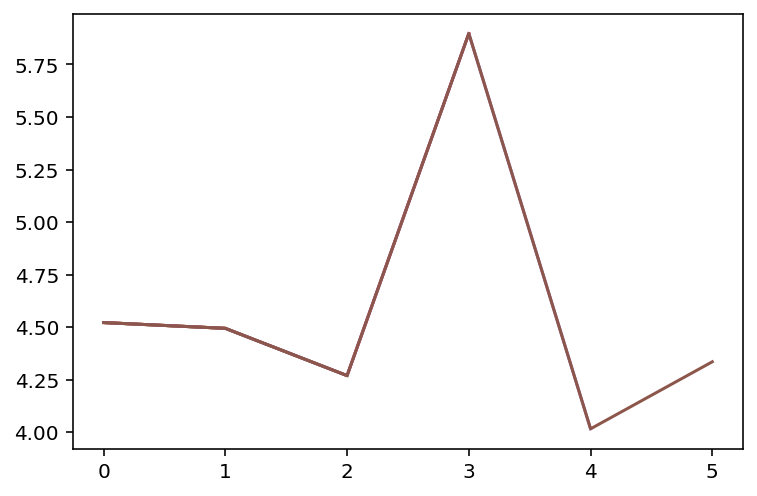

In [15]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:

        y_pred = music_gen_rnn(x)
        loss = compute_loss(y, y_pred)
        grads = tape.gradient(loss, music_gen_rnn.trainable_variables)

        optimizer.apply_gradients(zip(grads, music_gen_rnn.trainable_variables))
    return loss

history = []

for iter in tqdm(range(num_training_iterations)):
    x_batch, y_batch = make_random_batch(seq_length, batch_size)
    loss = train_step(x_batch, y_batch)

    history.append(loss.numpy().mean())
    plt.plot(history)

    if iter % 100 == 0:
        music_gen_rnn.save_weights(checkpoint_prefix)
    
music_gen_rnn.save_weights(checkpoint_prefix)

In [16]:
# Model for Generation
music_gen_rnn = musicGenRNN(len(musical_alphabet), embedding_dim=256, rnn_units=1024, batch_size=1)
music_gen_rnn.build((1, *input_shape))

# Chekpoint loading
music_gen_rnn.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
music_gen_rnn.build(tf.TensorShape([1, None]))

music_gen_rnn.summary()

Model: "music_gen_rnn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  23552     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  5246976   
_________________________________________________________________
dense_2 (Dense)              multiple                  94300     
Total params: 5,364,828
Trainable params: 5,364,828
Non-trainable params: 0
_________________________________________________________________


In [17]:
def predict_new_music(model, start_string, music_length):
    vectorised_input = np.array([char_to_scal[c] for c  in start_string])
    text_generated = []
    
    model.reset_states()
    
    vectorised_input = tf.expand_dims(vectorised_input, 0)
    
    for i in range(music_length):
        y_pred = model(vectorised_input)
        y_pred = tf.squeeze(y_pred, 0)
        y_id = tf.random.categorical(y_pred, 1)[-1,0].numpy()
        vectorised_input = tf.expand_dims([y_id], 0)
        text_generated.append(scal_to_char[y_id])
    
    return (start_string + ''.join(text_generated))

In [22]:
musics_generated = predict_new_music(music_gen_rnn, 'X:', 1000)
music = extract_song_snippet(musics_generated)

Found 0 songs in text


In [ ]:
# Play test music
abcScore = converter.parse(music)
sp = midi.realtime.StreamPlayer(abcScore)
sp.play()